# Working with automated computations: Imported tables

This session was modified from: https://github.com/vathes/playground_tutorial

In this session, we will learn to:

* import neuron imaging data from data files into an `Imported` table
* automatically trigger data importing and computations for all missing entries with `populate`

First thing first, let's update and import `datajoint` again.

In [6]:
!pip install --upgrade datajoint
import datajoint as dj

Requirement already up-to-date: datajoint in c:\programdata\anaconda3\lib\site-packages (0.12.5)


As we are going to perform some computations, let's go ahead and import NumPy and Matplotlib

In [38]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

Now we would like to work with the tables we define in `fly_session.py`. To do so, we would need the classes for each table: `Fly` and `Session`. We can either redefine it here, but for your convenience, you can also just import the file/package. We will use the schema object again to define more tables.

In [2]:
from fly_session import schema, Fly, Session

Connecting root@127.0.0.1:3306


In [3]:
Fly()

fly_id Unique animal ID,dob date of birth,sex sex
0,2020-03-01,M
1,2019-11-19,M
2,2019-11-20,U
5,2019-12-25,F
10,2020-01-01,F
11,2020-01-03,F
100,2020-05-12,F


In [4]:
Session()

fly_id Unique animal ID,session_date date,experiment_setup experiment setup ID,experimenter experimenter name,data_path
0,2020-05-15,0,gucky92,imaging_data
0,2020-05-19,0,gucky92,imaging_data
5,2020-01-05,1,jko14,imaging_data
100,2020-05-25,100,jportes,imaging_data


The `fly_session.py` also fills each table with data to make sure we are all on the same page.

## Define table `Scan` for meta information of each calcium imaging scan

Now let's define a table `Scan` that describes a scanning in an experimental session that stores the meta information of a particular scan.

In [27]:
@schema
class Scan(dj.Manual):
    definition = """
    -> Session
    scan_idx    : int           # scan index
    ---
    depth       : float         # depth of this scan
    wavelength  : float         # wavelength used
    laser_power : float         # power of the laser used
    fps         : float         # frames per second
    file_name    : varchar(128) # name of the tif file
    """

This table is dependent on the table `Session`, inheriting its primary key attributes, with an additional primary key attribute `scan_idx`. 

### 1) What type of relationship exists between `Session` and `Scan`?

Your answer here: one-to-many 

#### ERD

We could take a look at the ERD (entity-relational diagram) again.

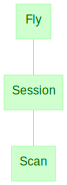

In [9]:
dj.ERD(schema)

The thin solid line connecting `Fly`-`Session`, and `Session`-`Scan` indicates **one-to-many relationship**.  

The `____` indicates **additional primary key attribute(s)** apart from the ones inherited from its parents.

Here we have prepared three tif files of scanning in the `imaging_data`

In [25]:
!ls imaging_data

example_scan_01.tif
example_scan_02.tif
example_scan_03.tif


In [26]:
Scan.insert([
    {'fly_id': 0, 'session_date': '2020-05-15', 'scan_idx': 1, 
     'depth': 150, 'wavelength': 920, 'laser_power': 26, 'fps': 15, 
     'file_name': 'example_scan_01.tif'},
    {'fly_id': 0, 'session_date': '2020-05-15', 'scan_idx': 2, 
     'depth': 200, 'wavelength': 920, 'laser_power': 24, 'fps': 15, 
     'file_name': 'example_scan_02.tif'},
])

DuplicateError: ("Duplicate entry '0-2020-05-15-1' for key 'PRIMARY'", 'To ignore duplicate entries in insert, set skip_duplicates=True')

In [12]:
Scan()

fly_id Unique animal ID,session_date date,scan_idx scan index,depth depth of this scan,wavelength wavelength used,laser_power power of the laser used,fps frames per second,file_name name of the tif file
0,2020-05-15,1,150.0,920.0,26.0,15.0,example_scan_01.tif
0,2020-05-15,2,200.0,920.0,24.0,15.0,example_scan_02.tif


## Looking at the raw data

Let's first load one raw data and take a look at the data:

In [34]:
from skimage import io
im = io.imread('imaging_data/example_scan_01.tif')
print(im.shape)
im

(100, 128, 128)


array([[[31, 28, 30, ..., 66, 58, 48],
        [36, 27, 26, ..., 76, 67, 48],
        [36, 27, 24, ..., 79, 69, 47],
        ...,
        [26, 24, 23, ..., 22, 17, 15],
        [26, 27, 26, ..., 21, 18, 16],
        [31, 33, 28, ..., 20, 19, 20]],

       [[48, 44, 38, ..., 74, 58, 48],
        [37, 30, 26, ..., 70, 59, 42],
        [31, 23, 21, ..., 67, 58, 41],
        ...,
        [27, 26, 23, ..., 20, 16, 14],
        [25, 26, 25, ..., 19, 16, 15],
        [33, 36, 30, ..., 18, 17, 18]],

       [[47, 47, 44, ..., 63, 49, 45],
        [37, 34, 32, ..., 60, 52, 42],
        [29, 24, 22, ..., 61, 55, 42],
        ...,
        [23, 22, 22, ..., 20, 15, 13],
        [22, 22, 22, ..., 19, 16, 15],
        [28, 30, 25, ..., 18, 17, 18]],

       ...,

       [[25, 20, 26, ..., 44, 49, 56],
        [27, 22, 24, ..., 42, 46, 49],
        [30, 23, 22, ..., 45, 47, 46],
        ...,
        [41, 40, 34, ..., 18, 24, 32],
        [43, 51, 46, ..., 19, 27, 36],
        [46, 59, 59, ..., 18, 24

This tiff file contains 100 frames. Let's take the average of the images over frames and look at it.

### 2) compute the avg frame with np.mean of axis=0 and plot the average image

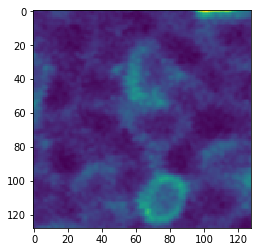

In [39]:
meanimage = np.mean(im,0)
imgplot = plt.imshow(meanimage)

## Defining table for average fluorescence across frames

Now let's create a table `AverageFrame` to compute and save the average fluorescence. 

For each scan, we have one average frame. Therefore, the table shares the exact same primary key as the table `Scan`

In [19]:
@schema
class AverageFrame(dj.Imported):
    definition = """
    -> Scan
    ---
    average_frame   : longblob     # average fluorescence across frames
    """

Let's check the state of our pipeline.

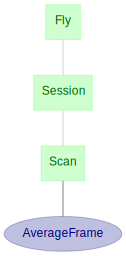

In [20]:
dj.ERD(schema)

Note that `AverageFrame` and `Scan` share the exact same primary key attributes, so `Scan` and `AverageFrame` have a **one-to-one** relationship, which is indicated with a thick solid line.

We defined `average_frame` as a `longblob` so that it can store a NumPy array. This NumPy array will be imported and computed from the file corresponding to each scan.

Note that our `AverageFrame` class inherits from `dj.Imported` instead of `dj.Manual` like others. This is because **this table's content will depend on data imported from an external file**. The `Manual` vs `Imported` are said to specify the **tier of the table**.

## DataJoint table tiers

In DataJoint, the tier of the table indicates **the nature of the data and the data source for the table**. So far we have encountered two table tiers: `Manual` and `Imported`, and we will encounter the two other major tiers in this session. 

DataJoint tables in `Manual` tier, or simply **Manual tables** indicate that its contents are **manually** entered by either experimenters or a recording system, and its content **do not depend on external data files or other tables**. This is the most basic table type you will encounter, especially as the tables at the beggining of the pipeline. In the ERD, `Manual` tables are depicted by green rectangles.

On the other hand, **Imported tables** are understood to pull data (or *import* data) from external data files, and come equipped with functionalities to perform this importing process automatically, as we will see shortly! In the ERD, `Imported` tables are depicted by blue ellipses (see above).

## Importing data into the `Imported` table

Rather than filling out the content of the table manually using `insert1` or `insert` methods, we are going to make use of the `make` and `populate` logic that comes with `Imported` tables to automatically figure out what needs to be imported and perform the import!

## `make` and `populate` methods

`Imported` table comes with a special method called `populate`. Let's try calling it.

In [21]:
AverageFrame.populate()

NotImplementedError: Subclasses of AutoPopulate must implement the method `make`

Notice that `populate` call complained that a method called `make` is not implemented. Let me show a simple `make` method that will help elucidate what this is all about.

In [22]:
@schema
class AverageFrame(dj.Imported):
    definition = """
    -> Scan
    ---
    average_frame   : longblob     # average fluorescence across frames
    """
    def make(self, key):  # key is the primary key of one of the entries in the table `Scan`
        print('key is', key)

Now, let's call `populate` again!

In [23]:
AverageFrame.populate()

key is {'fly_id': 0, 'session_date': datetime.date(2020, 5, 15), 'scan_idx': 1}
key is {'fly_id': 0, 'session_date': datetime.date(2020, 5, 15), 'scan_idx': 2}


When you call `populate` on an `Imported` table, this triggers DataJoint to look up all tables that the `Imported` table depends on.

For **every unique combination of entries in the depended or "parent" tables**, DataJoint calls `make` function, passing in the primary key of the parent(s).

Because `AverageFrame` depends on `Scan`, `AverageFrame`'s `make` method was called for each entry of `Scan`

In [24]:
Scan()

fly_id Unique animal ID,session_date date,scan_idx scan index,depth depth of this scan,wavelength wavelength used,laser_power power of the laser used,fps frames per second,file_name name of the tif file
0,2020-05-15,1,150.0,920.0,26.0,15.0,example_scan_01.tif
0,2020-05-15,2,200.0,920.0,24.0,15.0,example_scan_02.tif


Note that `make` only receives the *primary key attributes* of `Scan` (`mouse_id`, `session_date`, `scan_idx`) but not the other attributes.

## Implementing `make`

Now we have a better understanding of `make`, let's implement `make` to perform the importing of data from file.

In [58]:
Scan()

fly_id Unique animal ID,session_date date,scan_idx scan index,depth depth of this scan,wavelength wavelength used,laser_power power of the laser used,fps frames per second,file_name name of the tif file
0,2020-05-15,1,150.0,920.0,26.0,15.0,example_scan_01.tif
0,2020-05-15,2,200.0,920.0,24.0,15.0,example_scan_02.tif


In [83]:
Session()

fly_id Unique animal ID,session_date date,experiment_setup experiment setup ID,experimenter experimenter name,data_path
0,2020-05-15,0,gucky92,imaging_data
0,2020-05-19,0,gucky92,imaging_data
5,2020-01-05,1,jko14,imaging_data
100,2020-05-25,100,jportes,imaging_data


In [86]:
fly0sesh = (Session & {'session_date':'2020-05-15'}).fetch('data_path')
fly0sesh

array(['imaging_data'], dtype=object)

### 3) Implement a `make` function for `AverageFrame` to compute the average frame and insert it into the table. 

In [64]:
scandict = Scan.fetch("KEY")
scandict

[{'fly_id': 0, 'session_date': datetime.date(2020, 5, 15), 'scan_idx': 1},
 {'fly_id': 0, 'session_date': datetime.date(2020, 5, 15), 'scan_idx': 2}]

In [112]:
# Modify code here

import os
# import numpy as np
@schema
class AverageFrame(dj.Imported):
    definition = """
    -> Scan
    ---
    average_frame   : longblob     # average fluorescence across frames
    """
    def make(self, key):  # key is the primary key of one of the entries in the table `Scan`
        filename = (Scan & key).fetch1()['file_name']
        sessiondate = (Scan & key).fetch1()['session_date']
        filepath = (Session & {'session_date':sessiondate}).fetch1()['data_path']
        path = os.path.join(filepath,filename)
        im = io.imread(path)
        im.shape
#         average_frame = np.mean(im,0)
        averageframe = np.mean(im,0)
        key.update({'average_frame': averageframe})
        self.insert1(key)

In [105]:
# import os
# key = {'fly_id': 0, 'session_date': '2020-05-15', 'scan_idx': 1}
# filename = (Scan & key).fetch1()['file_name']
# sessiondate = (Scan & key).fetch1()['session_date']
# filepath = (Session & {'session_date':sessiondate}).fetch1()['data_path']
# path = os.path.join(filepath,filename)
# im = io.imread(path)
# im.shape
# meanimage = np.mean(im,0)

In [113]:
AverageFrame()

fly_id Unique animal ID,session_date date,scan_idx scan index,average_frame average fluorescence across frames


Hints: 
* Fetch the necessary data from `Session` and `Scan` using the `key` to restrict and the `fetch1` method.
* Once you compute the average frame add the `average_frame` into the `key` dictionary, and then insert it into the table (i.e. `self`) using the `insert1` method.

Finally, let's go ahead and call `populate` to actually populate the `AverageFrame` table, filling it with data loaded and computed from data files!

In [114]:
AverageFrame.populate()

Let's take a look at the table now.

In [115]:
AverageFrame()

fly_id Unique animal ID,session_date date,scan_idx scan index,average_frame average fluorescence across frames
0,2020-05-15,1,=BLOB=
0,2020-05-15,2,=BLOB=


What happens if we call `AverageFrame.populate` again?

In [116]:
AverageFrame.populate()

That's right - nothing! This makes sense, because we have computed `AverageFrame` for all entries in `Scan` and nothing is left to be computed.

Now what happens if we insert a new entry into `Scan`?

In [117]:
Scan.insert1({
    'fly_id': 100,
    'session_date': '2020-05-25',
    'scan_idx': 1,
    'depth': 150,
    'wavelength': 920,
    'laser_power': 25,
    'fps': 15,
    'file_name': 'example_scan_03.tif'
})

We can find all `Scan` without corresponding `AverageFrame` entry with the **negative restriction operator** `-`

In [118]:
# select all Scan entries *without* a corresponding entry in AverageFrame
Scan - AverageFrame

fly_id Unique animal ID,session_date date,scan_idx scan index,depth depth of this scan,wavelength wavelength used,laser_power power of the laser used,fps frames per second,file_name name of the tif file
100,2020-05-25,1,150.0,920.0,25.0,15.0,example_scan_03.tif


In [119]:
AverageFrame.populate(display_progress=True)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.91it/s]


`populate` found the uncomputed entry and processed it!

In [120]:
AverageFrame()

fly_id Unique animal ID,session_date date,scan_idx scan index,average_frame average fluorescence across frames
0,2020-05-15,1,=BLOB=
0,2020-05-15,2,=BLOB=
100,2020-05-25,1,=BLOB=


Now instead of loading from the raw tif file, we are able fetch the average fluorescence image from this table.

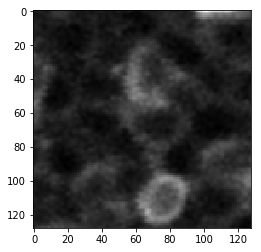

In [121]:
key = dict(fly_id=0, session_date='2020-05-15', scan_idx=1)
avg_image = (AverageFrame & key).fetch1('average_frame')
plt.imshow(avg_image, cmap=plt.cm.gray)

### 4) Add another `Imported` table called `Frames` that simple imports the whole movie into the database instead of computing the average.

Optional: define a datajoint external configuration instead of using longblob for this table

In [123]:
Session()

fly_id Unique animal ID,session_date date,experiment_setup experiment setup ID,experimenter experimenter name,data_path
0,2020-05-15,0,gucky92,imaging_data
0,2020-05-19,0,gucky92,imaging_data
5,2020-01-05,1,jko14,imaging_data
100,2020-05-25,100,jportes,imaging_data


In [124]:
Scan()

fly_id Unique animal ID,session_date date,scan_idx scan index,depth depth of this scan,wavelength wavelength used,laser_power power of the laser used,fps frames per second,file_name name of the tif file
0,2020-05-15,1,150.0,920.0,26.0,15.0,example_scan_01.tif
0,2020-05-15,2,200.0,920.0,24.0,15.0,example_scan_02.tif
100,2020-05-25,1,150.0,920.0,25.0,15.0,example_scan_03.tif


In [126]:
folder = os.getcwd()
dj.config['stores'] = {
    'localstore': {
        'protocol': 'file', # store is a normal filepath
        'location': os.path.join(folder, 'localstore') # location of store
    }
}
dj.config['stores'].update({
    'attachstore': {
        'protocol': 'file', # store is a normal filepath
        'location': os.path.join(folder, 'attachstore') # location of store
    }
})

In [127]:
folder

'D:\\Code\\PythonDataCourse\\Homeworks\\HW6'

In [128]:
@schema
class Frames(dj.Imported):
    definition = """
    -> Scan
    ---
    data : attach@attachstore
    """
    
    def make(self, key):  # key is the primary key of one of the entries in the table `Scan`
        filename = (Scan & key).fetch1()['file_name']
        sessiondate = (Scan & key).fetch1()['session_date']
        filepath = (Session & {'session_date':sessiondate}).fetch1()['data_path']
        key.update({'data': os.path.join(filepath,filename)})
        self.insert1(key)        

In [129]:
Frames().populate(display_progress=True)

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 11.01it/s]


In [130]:
Frames()

fly_id Unique animal ID,session_date date,scan_idx scan index,data
0,2020-05-15,2,=BLOB=
0,2020-05-15,1,=BLOB=
100,2020-05-25,1,=BLOB=


In [138]:
Frames.fetch(download_path='downloaded_vids')

array([(  0, datetime.date(2020, 5, 15), 2, 'downloaded_vids\\example_scan_02.tif'),
       (  0, datetime.date(2020, 5, 15), 1, 'downloaded_vids\\example_scan_01.tif'),
       (100, datetime.date(2020, 5, 25), 1, 'downloaded_vids\\example_scan_03.tif')],
      dtype=[('fly_id', '<i8'), ('session_date', 'O'), ('scan_idx', '<i8'), ('data', 'O')])

In [143]:
vid = (Frames&{'fly_id':100}).fetch(download_path='downloaded_vids')
vid

array([(100, datetime.date(2020, 5, 25), 1, 'downloaded_vids\\example_scan_03.tif')],
      dtype=[('fly_id', '<i8'), ('session_date', 'O'), ('scan_idx', '<i8'), ('data', 'O')])

## Summary

Congratulations! You have successfully extended your pipeline with a table to represent processed data (`AverageFrame` and `Frames` as `Imported` table), learned and implemented the `make()` and `populate()` call to load external data to your tables.

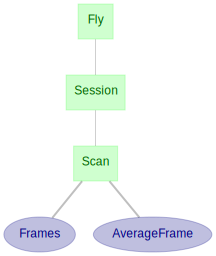

In [144]:
dj.ERD(schema)

At this point, our pipeline contains the core elements with data populated, ready for further downstream analysis.

Go to Part 2 of this homework